GAN Construction


In [5]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Configurations

In [12]:
device  = "cuda"
batch_size = 128
noise_dim = 64 # shape of random noise vector to be passed in tge generator
lr  = 2e-3
beta1 = 0.5
epochs = 20
beta2 = 0.99

# generator generates images, discriminator decides whether the passed image is fake or real


# Load MNIST Dataset

In [2]:
from torchvision import datasets, transforms as T
train_augs = T.Compose([T.RandomRotation((-20,20)),T.ToTensor()])

In [3]:
train_set = datasets.MNIST('MNIST/',train = True,download = True, transform = train_augs)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 12588248.32it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 341696.06it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:01<00:00, 1339041.08it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 4050718.43it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



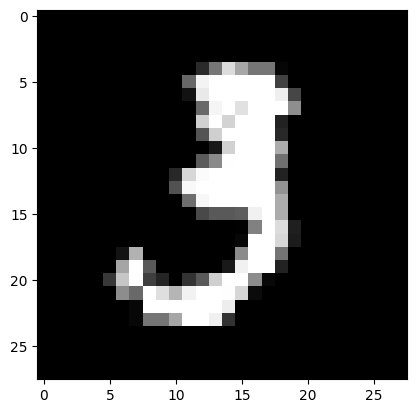

In [8]:
image,label = train_set[10]
plt.imshow(image.squeeze(),cmap = "gray")

In [9]:
total_images = len(train_set)

# Load Dataset Into Batches

In [10]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [13]:
train_loader = DataLoader(train_set,batch_size = batch_size,shuffle = True)

In [15]:
num_batches = len(train_loader)
print(num_batches)

469


In [ ]:
dataiter = iter(train_loader)
images,_ = dataiter.next()

In [46]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Create Discriminator Network

In [18]:
#In case if torch summary is not installed

!pip install torchsummary

In [19]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [26]:
def GetDiscriminatorBlock(in_channels,out_channels,kernel_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [27]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.block1 = GetDiscriminatorBlock(1,16,(3,3),2)
    self.block2 = GetDiscriminatorBlock(16,32,(5,5),2)
    self.block3 = GetDiscriminatorBlock(32,64,(5,5),2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64,out_features = 1)

  def forward(self,images):
    x1 = self.block1(images)
    x2 = self.block2(x1)
    x2 = self.block3(x2)
    x2 = self.flatten(x2)
    x2 = self.linear(x2)
    return x2


In [41]:
D = Discriminator()
D.to(device)
summary(D,input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [29]:
### create generator network
def GetGenBlock(in_channels, out_channels, kernel_size, stride,final_block = False):
  if final_block:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.Tanh()
  )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )



In [37]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()
    self.noise_dim = noise_dim
    self.genb1 = GetGenBlock(in_channels = self.noise_dim, out_channels = 256, kernel_size = (3,3), stride = 2)
    self.genb2 = GetGenBlock(in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)
    self.genb3 = GetGenBlock(in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)
    self.genb4 = GetGenBlock( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2,final_block = True)

  def forward(self,noise_vec):
    # change noise_vec shape to (bs, noise_dim,1,1)
    noise_vec = noise_vec.view(-1,self.noise_dim,1,1)
    x1 = self.genb1(noise_vec)
    x1 = self.genb2(x1)
    x1 = self.genb3(x1)
    x1 = self.genb4(x1)
    return x1




In [38]:
G = Generator(noise_dim)
G.to(device)
summary(G,input_size = (1,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
      BatchNorm2d-11            [-1, 1, 28, 28]               2
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 747,843
Trainable params: 747,843
Non-trainable params: 0
-------------------------------

In [42]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [43]:
D= D.apply(weights_init)
G= G.apply(weights_init)


# Create Loss Function and Load Optimizer

In [44]:
def real_loss(D_preds):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(D_preds)
  loss = criterion(D_preds,ground_truth)
  return loss

def fake_loss(D_preds):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(D_preds)
  loss = criterion(D_preds,ground_truth)
  return loss


In [45]:
d_opt = torch.optim.Adam(D.parameters(),lr,betas = (beta1,beta2))
g_opt = torch.optim.Adam(G.parameters(),lr,betas = (beta1,beta2))


# Training Loop

Epoch: 1 | Discriminator Loss: 0.060155423730040895 | Generator Loss: 7.436643037968861


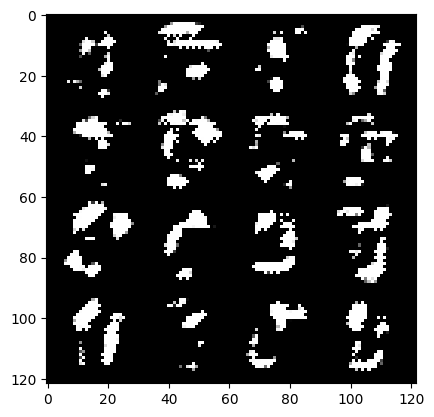

Epoch: 2 | Discriminator Loss: 0.054587740219880276 | Generator Loss: 7.577396340461682


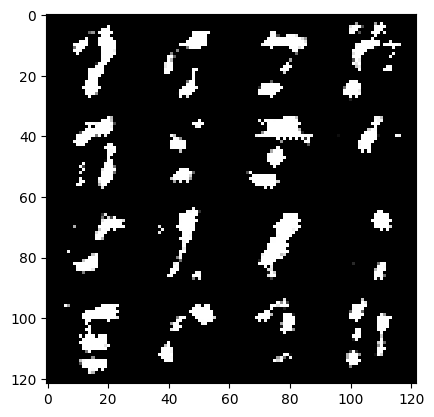

Epoch: 3 | Discriminator Loss: 0.05683084280698745 | Generator Loss: 5.932010616829146


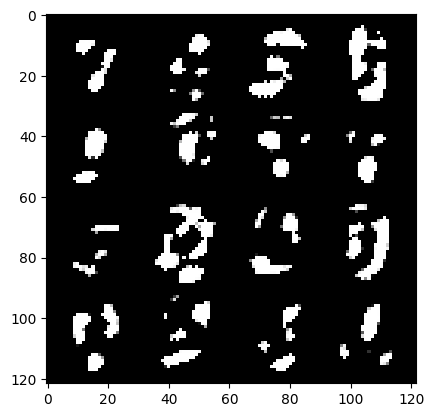

Epoch: 4 | Discriminator Loss: 0.07110176602604865 | Generator Loss: 5.091833675593964


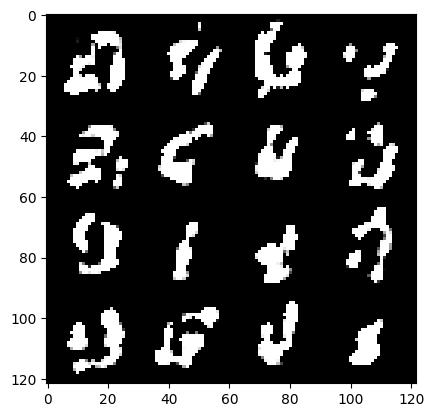

Epoch: 5 | Discriminator Loss: 0.08342425552790543 | Generator Loss: 5.4010045286307715


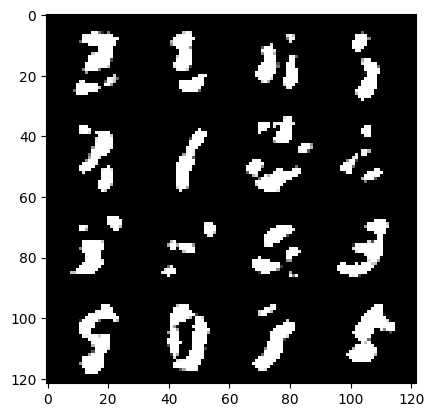

Epoch: 6 | Discriminator Loss: 0.06616145779869195 | Generator Loss: 5.6431588522915135


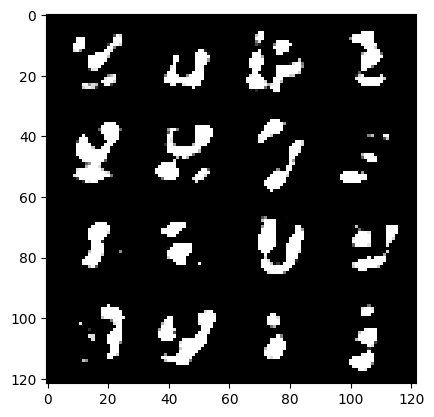

Epoch: 7 | Discriminator Loss: 0.05461162883542113 | Generator Loss: 5.7803347242920635


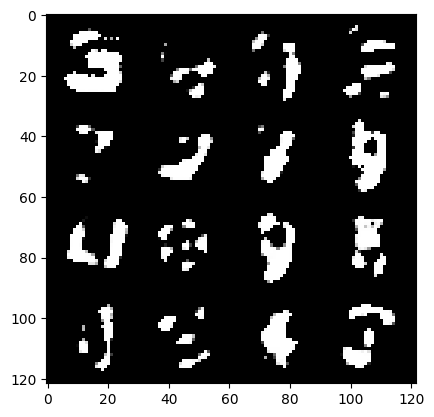

Epoch: 8 | Discriminator Loss: 0.0757393160922282 | Generator Loss: 5.658674941642452


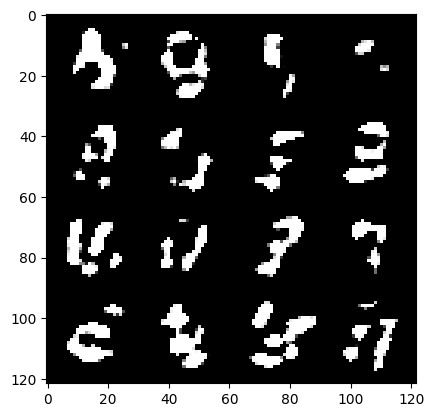

Epoch: 9 | Discriminator Loss: 0.12640510188209128 | Generator Loss: 5.1176601926655145


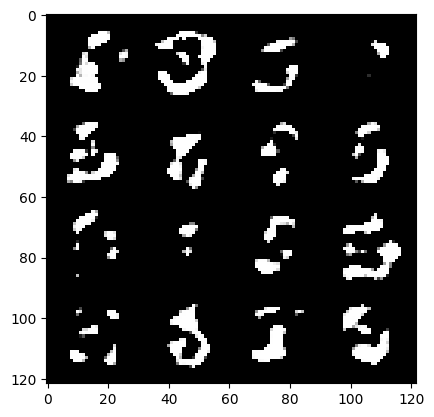

Epoch: 10 | Discriminator Loss: 0.07733790957029345 | Generator Loss: 5.421272889129134


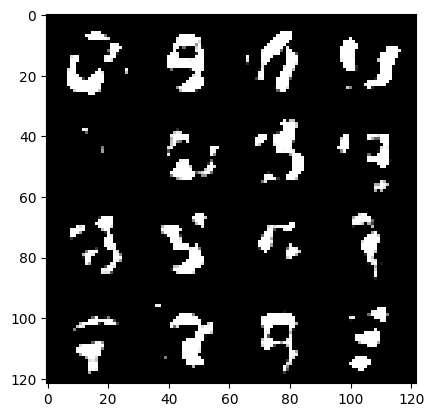

Epoch: 11 | Discriminator Loss: 0.07141059430649699 | Generator Loss: 5.2981623298069564


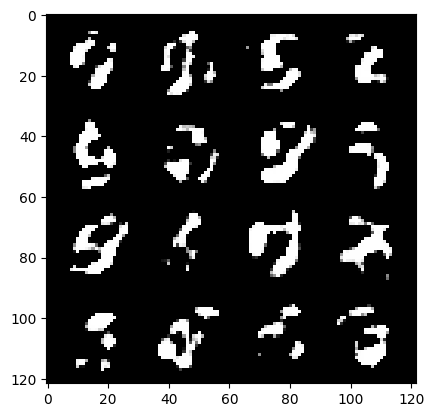

Epoch: 12 | Discriminator Loss: 0.08269002428576191 | Generator Loss: 5.173578594285034


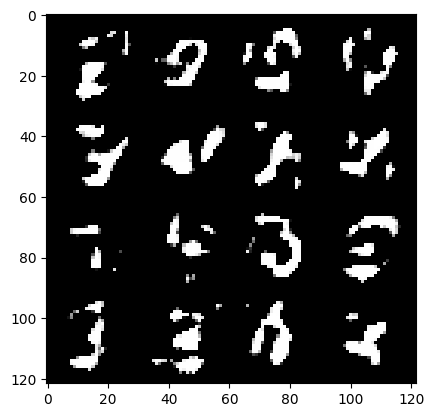

Epoch: 13 | Discriminator Loss: 0.09248884593738295 | Generator Loss: 5.076909617193218


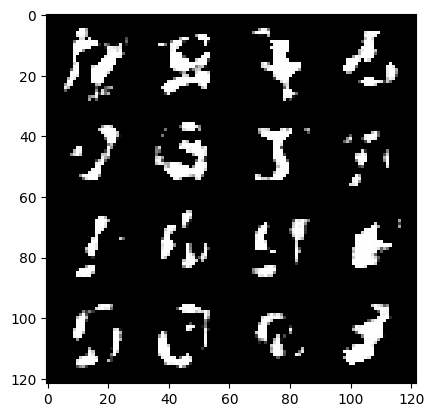

Epoch: 14 | Discriminator Loss: 0.08269565181929801 | Generator Loss: 4.91213284779205


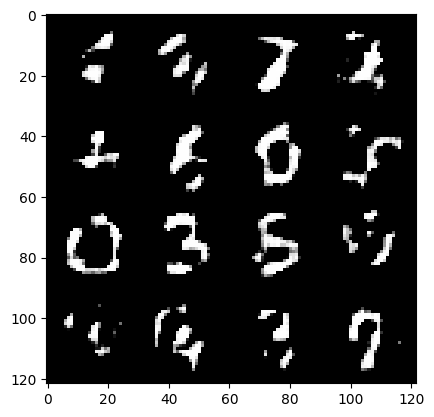

Epoch: 15 | Discriminator Loss: 0.08564536272685157 | Generator Loss: 4.985356917259281


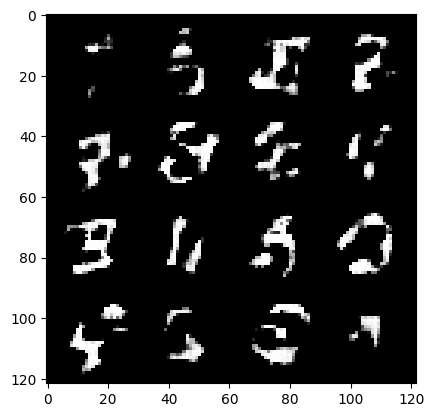

Epoch: 16 | Discriminator Loss: 0.09206157362759748 | Generator Loss: 4.986836018084463


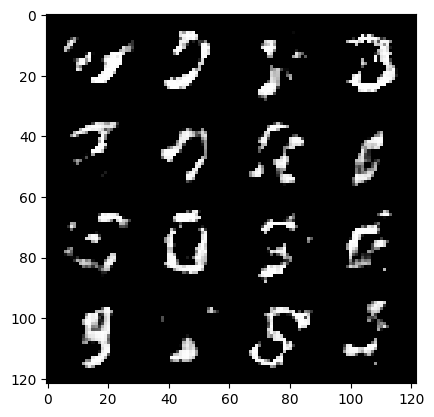

Epoch: 17 | Discriminator Loss: 0.09704506404396059 | Generator Loss: 5.086091846799546


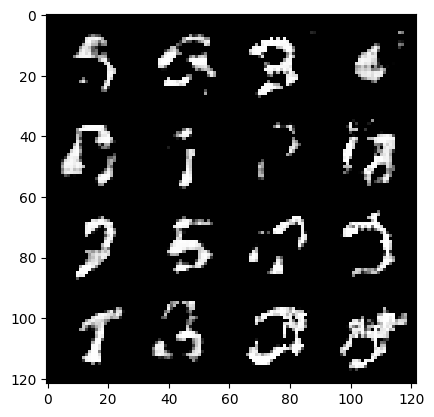

Epoch: 18 | Discriminator Loss: 0.08285265956828589 | Generator Loss: 5.215428267460642


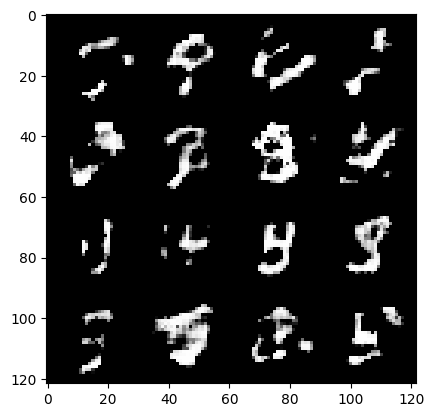

Epoch: 19 | Discriminator Loss: 0.09949287995378346 | Generator Loss: 5.320937708750971


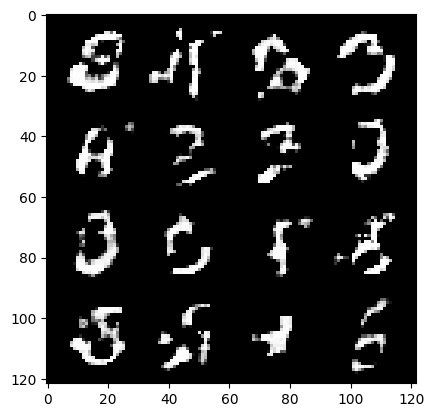

Epoch: 20 | Discriminator Loss: 0.10991849355510812 | Generator Loss: 5.322346068140286


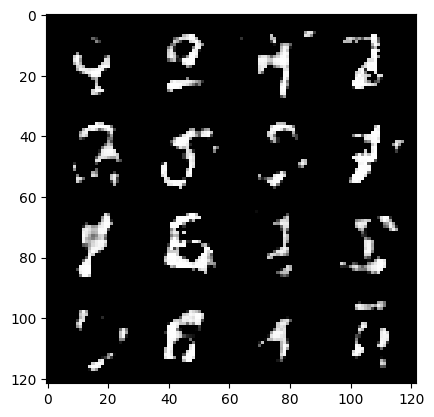

In [48]:
for i in range(epochs):
  total_d_loss = 0
  total_g_loss = 0
  for real_img,_ in train_loader:
    ### loss for discriminator
    real_img = real_img.to(device)
    noise = torch.randn(batch_size,noise_dim,device = device)
    d_opt.zero_grad()
    fake_img = G(noise)
    d_pred = D(fake_img)
    d_fake_loss = fake_loss(d_pred)
    d_pred = D(real_img)
    d_real_loss = real_loss(d_pred)
    d_loss = (d_real_loss + d_fake_loss)/2
    total_d_loss+=d_loss.item()
    d_loss.backward()
    d_opt.step()


    ## optimization for generator
    g_opt.zero_grad()

    noise = torch.randn(batch_size,noise_dim,device = device)
    fake_img = G(noise)
    d_pred = D(fake_img)
    g_loss = real_loss(d_pred)
    total_g_loss+=g_loss.item()
    g_loss.backward()
    g_opt.step()
  avg_d_loss = total_d_loss/len(train_loader)
  avg_g_loss = total_g_loss/len(train_loader)
  print("Epoch: {} | Discriminator Loss: {} | Generator Loss: {}".format(i+1,avg_d_loss,avg_g_loss))
  show_tensor_images(fake_img)


In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)